In [1]:
import rasterio
import numpy as np
from scipy.interpolate import griddata

def interpolate_saved_geotiff(file_path, new_resolution, save_path):
    """
    读取保存的GeoTIFF文件并对数据进行插值。
    
    :param file_path: str, 已保存的GeoTIFF文件路径
    :param new_resolution: tuple, (新分辨率的行数, 新分辨率的列数)
    :param save_path: str, 插值后保存的新GeoTIFF文件路径
    :return: np.ndarray, 插值后的数据
    """
    try:
        # 打开GeoTIFF文件
        with rasterio.open(file_path) as dataset:
            # 获取原始数据
            data = dataset.read(1)
            transform = dataset.transform
            crs = dataset.crs
            profile = dataset.profile

            # 获取原始数据的网格坐标
            rows, cols = data.shape
            x = np.linspace(transform[2], transform[2] + transform[0] * cols, cols)
            y = np.linspace(transform[5], transform[5] + transform[4] * rows, rows)
            xv, yv = np.meshgrid(x, y)

            # 去除无效值（NaN）
            valid_mask = ~np.isnan(data)
            valid_points = np.array([xv[valid_mask], yv[valid_mask]]).T
            valid_values = data[valid_mask]

            # 创建新的网格坐标
            new_x = np.linspace(x.min(), x.max(), new_resolution[1])
            new_y = np.linspace(y.min(), y.max(), new_resolution[0])
            new_xv, new_yv = np.meshgrid(new_x, new_y)

            # 对数据进行插值
            interpolated_data = griddata(valid_points, valid_values, (new_xv, new_yv), method='linear')

            # 更新GeoTIFF元数据
            new_transform = rasterio.transform.from_bounds(new_x.min(), new_y.min(), new_x.max(), new_y.max(),
                                                           new_resolution[1], new_resolution[0])
            profile.update({
                'height': new_resolution[0],
                'width': new_resolution[1],
                'transform': new_transform,
                'dtype': 'float32'
            })

            # 保存插值后的GeoTIFF文件
            with rasterio.open(save_path, 'w', **profile) as dst:
                dst.write(interpolated_data.astype(rasterio.float32), 1)

            print(f"插值后的GeoTIFF文件已保存至: {save_path}")
            return interpolated_data

    except Exception as e:
        print(f"读取或插值GeoTIFF文件时发生错误: {e}")
        return None


In [2]:
file_path = "./output/filtered_data.tif"
new_resolution = (1000, 1000)  # 新的行数和列数
save_path = "./output/interpolated_data.tif"

interpolated_data = interpolate_saved_geotiff(file_path, new_resolution, save_path)

if interpolated_data is not None:
    print("插值成功，插值后数据的形状:", interpolated_data.shape)
else:
    print("插值失败")


插值后的GeoTIFF文件已保存至: ./output/interpolated_data.tif
插值成功，插值后数据的形状: (1000, 1000)


In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_geotiff(file_path, azimuth=45, elevation=30, save_path=None):
    """
    可视化GeoTIFF文件的三维地形图。
    
    :param file_path: str, GeoTIFF文件路径
    :param azimuth: float, 三维图的视角方位角（默认45度）
    :param elevation: float, 三维图的视角仰角（默认30度）
    :param save_path: str, 保存可视化图像的路径（可选）
    """
    try:
        # 打开GeoTIFF文件
        with rasterio.open(file_path) as dataset:
            # 获取数据
            data = dataset.read(1)
            transform = dataset.transform

            # 创建网格坐标
            rows, cols = data.shape
            x = np.linspace(transform[2], transform[2] + transform[0] * cols, cols)
            y = np.linspace(transform[5], transform[5] + transform[4] * rows, rows)
            xv, yv = np.meshgrid(x, y)

            # 去除无效值（NaN）
            valid_mask = ~np.isnan(data)
            xv = xv[valid_mask]
            yv = yv[valid_mask]
            zv = data[valid_mask]

            # 创建三维图
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_trisurf(xv, yv, zv, cmap='terrain', linewidth=0.2, antialiased=True)

            # 设置视角
            ax.view_init(elev=elevation, azim=azimuth)

            # 添加标签
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.set_zlabel("Elevation (m)")
            ax.set_title("3D Visualization of GeoTIFF Data")

            # 保存图像
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"三维地形图已保存至: {save_path}")

            # 显示图像
            plt.show()

    except Exception as e:
        print(f"三维可视化时发生错误: {e}")


三维地形图已保存至: ./output/3d_terrain_visualization.png


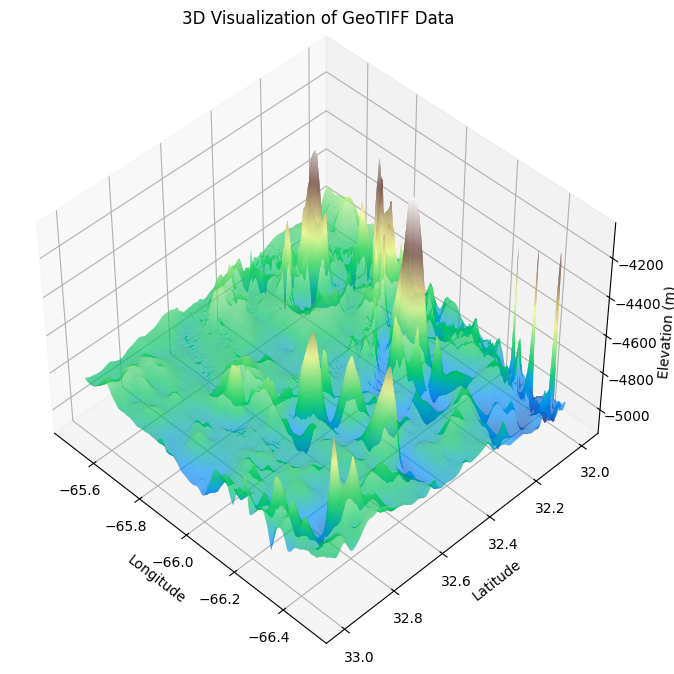

In [4]:
file_path = "./output/interpolated_data.tif"
azimuth = 135  # 自定义视角方位角
elevation = 45  # 自定义视角仰角
save_path = "./output/3d_terrain_visualization.png"

visualize_3d_geotiff(file_path, azimuth, elevation, save_path)
